In [ ]:
# ------------------------------------------------------------
# Лабораторная 1. Линейная регрессия на датасете Student Performance
# ------------------------------------------------------------

# 1. Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (mean_squared_error, r2_score,
                             confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score)
from sklearn.linear_model import LinearRegression
import requests, zipfile, io




In [ ]:

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
response = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(response.content))
df = pd.read_csv(z.open('student-mat.csv'), sep=';')



In [ ]:
# 3. Создаём бинарный флаг: сдал (G3 >= 10)
df['passed'] = (df['G3'] >= 10).astype(int)



In [ ]:
# 4. Отделяем признаки и целевые переменные
X = df.drop(columns=['G3', 'passed'])  # все признаки
y_reg = df['G3']                       # цель для регрессии



In [ ]:
# 5. Определяем типы признаков
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns



In [ ]:
# 6. Препроцессинг: категориальные -> One-Hot, числовые оставляем как есть
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])



In [ ]:
# 7. Строим пайплайн: сначала препроцессинг, затем линейная регрессия
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

# 8. Делим данные на train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=42)

# 9. Обучаем модель
pipeline.fit(X_train, y_train)

# 10. Делаем прогноз
y_pred = pipeline.predict(X_test)

# 11. Считаем метрики регрессии
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.3f}")



RMSE: 2.38
R²  : 0.724


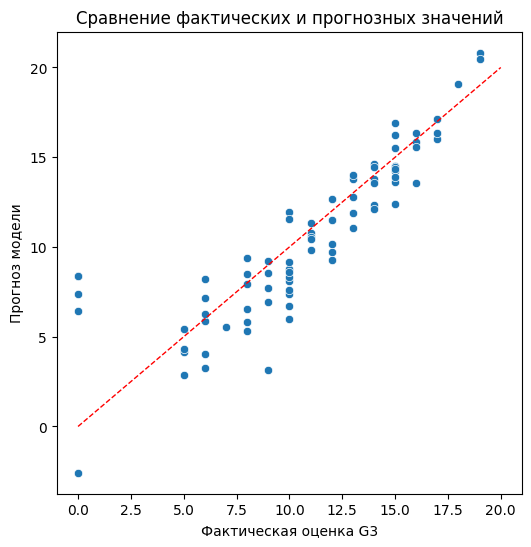

Accuracy (сдал/не сдал): 0.848


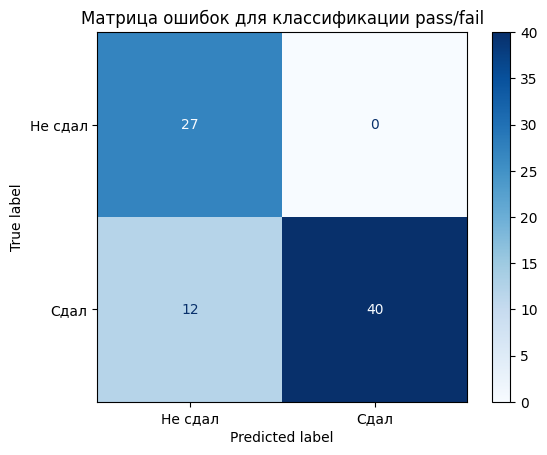

In [ ]:
# 12. Рисуем график «факт vs прогноз»
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([0, 20], [0, 20], 'r--', linewidth=1)   # идеальная линия
plt.xlabel('Фактическая оценка G3')
plt.ylabel('Прогноз модели')
plt.title('Сравнение фактических и прогнозных значений')
plt.show()

# 13. Готовим данные для матрицы ошибок
y_test_bin = (y_test >= 10).astype(int)     # истинные метки
y_pred_bin = (y_pred >= 10).astype(int)     # прогноз >=10 – считаем «сдал»

# 14. Confusion Matrix + Accuracy
cm = confusion_matrix(y_test_bin, y_pred_bin)
acc = accuracy_score(y_test_bin, y_pred_bin)
print(f"Accuracy (сдал/не сдал): {acc:.3f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Не сдал', 'Сдал'])
disp.plot(cmap='Blues')
plt.title('Матрица ошибок для классификации pass/fail')
plt.show()